Задание
Представьте, что вы работаете аналитиком в очень крупной компании по доставке пиццы над приложением для курьеров (да, обычно в таких компаниях есть приложение для курьеров и отдельно приложение для потребителей).

У вас есть несколько ресторанов в разных частях города и целый штат курьеров. Но есть одна проблема — к вечеру скорость доставки падает из-за того, что курьеры уходят домой после рабочего дня, а количество заказов лишь растет. Это приводит к тому, что в момент пересмены наша доставка очень сильно проседает в эффективности. 

Наши data scientist-ы придумали новый алгоритм, который позволяет курьерам запланировать свои последние заказы перед окончанием рабочего дня так, чтобы их маршрут доставки совпадал с маршрутом до дома. То есть, чтобы курьеры доставляли последние свои заказы за день как бы "по пути" домой. 

Вы вместе с командой решили раскатить A/B тест на две равные группы курьеров. Часть курьеров использует старый алгоритм без опции "по пути", другие видят в своем приложении эту опцию и могут ее выбрать. Ваша задача – проанализировать данные эксперимента и помочь бизнесу принять решение о раскатке новой фичи на всех курьеров.

Описание данных:
    
order_id - id заказа

delivery_time - время доставки в минутах

district - район доставки

experiment_group - экспериментальная группа

In [2]:
# required libraries
import pandas as pd
import numpy as np
from scipy import stats
import requests
from urllib.parse import urlencode
import datetime
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
df=pd.read_csv('experiment_lesson_4.csv')

In [41]:
df.head()

,order_id,delivery_time,district,experiment_group
0,3159,44.0,Purlieus,control
1,10426,51.0,Purlieus,control
2,9155,46.0,Purlieus,control
3,10699,34.0,Purlieus,control
4,10061,43.0,Purlieus,control


In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20196 entries, 0 to 20195
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   order_id          20196 non-null  int64  
 1   delivery_time     20196 non-null  float64
 2   district          20196 non-null  object 
 3   experiment_group  20196 non-null  object 
dtypes: float64(1), int64(1), object(2)
memory usage: 631.2+ KB


In [43]:
df.nunique()

order_id            20196
delivery_time          72
district                3
experiment_group        2
dtype: int64

Сопоставьте графики распределения и  экспериментальные группы:

<AxesSubplot:xlabel='delivery_time', ylabel='Count'>

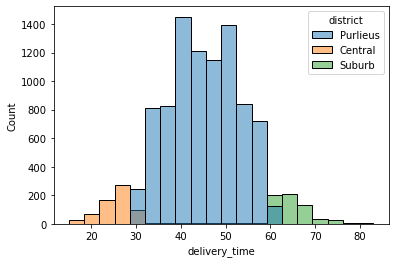

In [37]:
sns.histplot(data=df.query('experiment_group=="control"'), hue='district', x='delivery_time', bins=20)

district
Central     AxesSubplot(0.125,0.125;0.775x0.755)
Purlieus    AxesSubplot(0.125,0.125;0.775x0.755)
Suburb      AxesSubplot(0.125,0.125;0.775x0.755)
Name: delivery_time, dtype: object

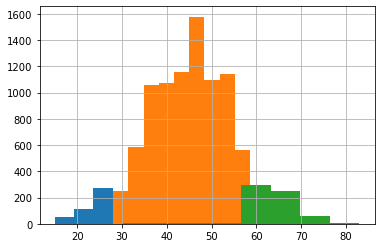

In [39]:
df.query('experiment_group=="control"').groupby('district').delivery_time.hist()

<AxesSubplot:xlabel='delivery_time', ylabel='Count'>

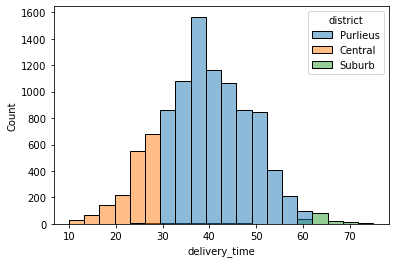

In [32]:
sns.histplot(data=df.query('experiment_group=="test"'), hue='district', x='delivery_time', bins=20)

district
Central     AxesSubplot(0.125,0.125;0.775x0.755)
Purlieus    AxesSubplot(0.125,0.125;0.775x0.755)
Suburb      AxesSubplot(0.125,0.125;0.775x0.755)
Name: delivery_time, dtype: object

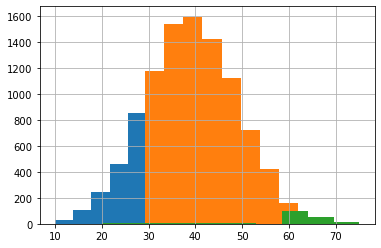

In [40]:
df.query('experiment_group=="test"').groupby('district').delivery_time.hist()

Посчитайте количество наблюдений в тестовой и контрольной группе. На сколько по модулю отличается количество наблюдений в тесте и контроле?

In [45]:
abs(df.query('experiment_group=="test"').order_id.count()-df.query('experiment_group=="control"').order_id.count())

12

Теперь давайте изучим наши распределения. Проверим выполнение условий на нормальность и посчитаем стандартное отклонение в тесте и в контроле.

Обязательно сделайте семплирование перед применением критерия при проверке на нормальность (и для теста, и для контроля), так как на больших выборках вы можете получать неверные результаты: 

experiment[experiment['experiment_group'] == 'test']['delivery_time'].sample(1000, random_state=17)

Почему тест может дать здесь неправильный ответ? Загляните в подсказки - в первом пункте мы постарались осветить этот момент подробнее :)

Заполните пропуски ниже:

Для того, чтобы проверить нормальность распределения, я использую 
ВЫБРАТЬ
. Этот тест показывает, что значения в тестовой группе распределены 
ВЫБРАТЬ
. В контрольной группе распределение является 
ВЫБРАТЬ
. Стандартное отклонение времени доставки в тесте равно (округлите до сотых) 
ВЫБРАТЬ
. Стандартное отклонение времени доставки в контроле равно (округлите до сотых) 
ВЫБРАТЬ
.

In [ ]:
df[experiment['experiment_group'] == 'test']['delivery_time'].sample(1000, random_state=17)

In [57]:
stats.shapiro(df[df['experiment_group'] == 'control']['delivery_time'].sample(1000, random_state=17))

ShapiroResult(statistic=0.9974725842475891, pvalue=0.12411931157112122)

Распределение выше нормальное

In [58]:
stats.shapiro(df[df['experiment_group'] == 'test']['delivery_time'].sample(1000, random_state=17))

ShapiroResult(statistic=0.9975475668907166, pvalue=0.14005419611930847)

Распределение выше нормальное

In [55]:
np.std(df[df['experiment_group'] == 'test']['delivery_time'])

9.882819260031312

In [56]:
np.std(df[df['experiment_group'] == 'control']['delivery_time'])

9.989522000653128

Пришло время сравнить средние в тесте и контроле. Внимание: здесь уже не нужно пользоваться методом .sample() — он нам нужен был только для теста Шапиро-Уилка, остальные тесты надо проводить на полных данных.

Заполните пропуски ниже:

Для сравнения средних в данных экспериментальных группах я использую 
ВЫБРАТЬ
. Статистика в тесте равна (округлите до целого) 
ВЫБРАТЬ
, p-value 
ВЫБРАТЬ
.

In [59]:
stats.ttest_ind(df[df['experiment_group'] == 'test']['delivery_time'],\
                df[df['experiment_group'] == 'control']['delivery_time'])

Ttest_indResult(statistic=-43.03582663183714, pvalue=0.0)

Ответ: Значимое отличие. Применялся тест Т-Стьюдента.

На сколько процентов изменилось среднее время доставки в тестовой группе по сравнению с контрольной (округлите до сотых)? 

Знак изменения необходимо учесть!

In [63]:
mean_delivery_test=df[df['experiment_group'] == 'test']['delivery_time'].mean()

In [64]:
mean_delivery_test

39.04681314330958

In [65]:
mean_delivery_control=df[df['experiment_group'] == 'control']['delivery_time'].mean()

In [66]:
mean_delivery_control

45.065101070154576

In [68]:
round((mean_delivery_test-mean_delivery_control)/mean_delivery_control*100,2)

-13.35